# Requirements

In [1]:
'''
분봉 데이터 제작
'''

import os
import pandas as pd
import numpy as np
import sqlite3
import win32com.client
import time
from datetime import datetime

today = datetime.now()
todaystamp = today.year * 10000 + today.month * 100 + today.day 


# Creon data loading

In [2]:

## 종목 데이터 호출 Class
class StockChart:
    def __init__(self, stock_code):
        self.CpCodeMgr = win32com.client.Dispatch("CpUtil.CpCodeMgr")
        self.StockChart = win32com.client.Dispatch("CpSysDib.StockChart")
        self.CpStatus = win32com.client.Dispatch("CpUtil.CpCybos")

        '''
        파라미터 종류
        stock_code : 종목코드
        flag : 호출 데이터(거래대금까지, 매매동향까지)
        '''

        self.stock_code = stock_code

        ## 입력 변수에 따른 호출데이터 설정
        self.start_date = self.CpCodeMgr.GetstockListedDate(stock_code)


    ## 데이터 호출 후 대기 시간 확인용
    def checkRemainTime(self):
        remainTime = self.CpStatus.LimitRequestRemainTime
        remainCount = self.CpStatus.GetLimitRemainCount(1) # 시세 제한 갯수
 
        if remainCount <= 0:
                timeStart = time.time()
                while remainCount <= 0 :
                    time.sleep(remainTime/1000)
                    remainCount = self.CpStatus.GetLimitRemainCount(1)  # 시세 제한
                    remainTime = self.CpStatus.LimitRequestRemainTime   
                ellapsed = time.time() - timeStart
                print("수신 대기: %.2f 초" %ellapsed)


    ## 분, 틱 데이터 호출 Method
    def call_stock_data_minute_tick(self, period, todaystamp=0, adjusted=0):

        fromDate = self.CpCodeMgr.GetstockListedDate(self.stock_code)        
        count = 9999999
        data_array_price_volume = [0, 1, 2, 3, 4, 5, 8]

        self.StockChart.SetInputValue(0, self.stock_code)  # 종목코드
        self.StockChart.SetInputValue(1, ord('2'))  # 갯수로 받기
        self.StockChart.SetInputValue(4, count)  # 갯수
        self.StockChart.SetInputValue(5, data_array_price_volume) # 호출 데이터
        self.StockChart.SetInputValue(6, ord('m')) # 차트 구분 (분)
        self.StockChart.SetInputValue(7, period) # 분봉 단위
        # self.StockChart.SetInputValue(9, ord('1'))  # 수정주가 사용
        self.StockChart.SetInputValue(9, ord(str(adjusted)))  # 수정주가 사용

        # raw_data_column = ('Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TradeVolume')
        raw_data_column = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']

        stock_raw_data = []
        receive_data = {} ## 딕셔너리 형태

        for col in raw_data_column:
            receive_data[col] = []

        receive_count = 0

        while count > receive_count:
            self.StockChart.BlockRequest()  # 요청 후 응답 대기
            self.checkRemainTime()

            receive_batch_len = self.StockChart.GetHeaderValue(3)  # 받아온 데이터 개수
            receive_batch_len = min(receive_batch_len, count - receive_count) # 정확히 count 개수만큼 받기 위함

            ## 데이터 수신하여 딕셔너리에 저장
            for i in range(receive_batch_len):
                for col_idx, col in enumerate(raw_data_column):
                    receive_data[col].append(self.StockChart.GetDataValue(col_idx, i))

            receive_count += receive_batch_len
            ## print('{} / {}'.format(receive_count, count))

            # 서버가 가진 모든 데이터를 요청한 경우 break.
            if not self.StockChart.Continue:
                break

        ## 날짜와 분봉의 합치
        # receive_data['Date'] = list(map(lambda x, y: int('{}{:04}'.format(x, y)), receive_data['Date'], receive_data['Time']))
        receive_data['date'] = list(map(lambda x, y: ('{}{:04}'.format(x, y)), receive_data['date'], receive_data['time']))
        del receive_data['time']
        raw_data_column.remove('time')
        ## 데이터프레임 형태로 변환
        ## 다만 호출한 데이터를 그대로 쓰게되면 날짜가 최신 -> 옛날순으로 가므로 리버스해서 역순에서 정순을 바꿔준다.
        # stock_raw_data = pd.DataFrame(receive_data, columns = ['Date', 'Open', 'High', 'Low', 'Close', 'TradeVolume'])
        stock_raw_data = pd.DataFrame(receive_data, columns=['open', 'high', 'low', 'close', 'volume'], index=receive_data['date'])        
        
        timeIndex = pd.to_datetime(stock_raw_data.index.astype(str))
        stock_raw_data.index = timeIndex
        stock_raw_data = stock_raw_data.sort_index() # 마지막 행이 최신 데이터

        return stock_raw_data # [::-1]


## 호출한 주가 데이터를 DB 파일로 저장
class ExportDatabase:
    def __init__(self, period, code_list, adjusted, base_date, data_len_thr):
        self.CpCodeMgr = win32com.client.Dispatch("CpUtil.CpCodeMgr")
        self.code_list = code_list
        self.period = period
        self.adjusted = adjusted
        self.base_date = base_date
        self.data_len_thr = data_len_thr

    ## 데이터 수신하여 DB파일에 저장
    def MakeDatabase(self):

        ## 분봉 데이터 저장(분단위 별로 나누어 저장)
        kospi = self.CpCodeMgr.GetstockListByMarket(1) # 코스피
        kosdaq = self.CpCodeMgr.GetstockListByMarket(2) # 코스닥
        
        # code_list = ['A005930' ] #, 'A233740', 'A229200', 'A251340', 'A069500', 'A119200', 'A122630', 'A252670']
        code_list = self.code_list #, 'A233740', 'A229200', 'A251340', 'A069500', 'A119200', 'A122630', 'A252670']

        # base_date = datetime.today().strftime('%Y%m%d')
        base_date = self.base_date
        
        save_path = 'D:\\Projects\\System_Trading\\JnQ\\candlestick_concated\\database_creon\\cum\\{}'.format(base_date)
        os.makedirs(save_path, exist_ok=True)
        
        ## 분봉 데이터 저장(분단위 별로 나누어 저장)
        if type(self.period) is int:
            print('%s분봉 데이터 수집' %self.period)
            # con = sqlite3.connect('stock_data_%sminute.db' %self.period)

            for i in range(len(code_list)):
                stockchart = StockChart(code_list[i])
                # stock_raw_data = stockchart.call_stock_data_minute_tick(self.period, adjusted=self.adjusted)
                
                # 유효구간 검증 logic
                stock_raw_data_0 = stockchart.call_stock_data_minute_tick(self.period, adjusted=0)
                
                if len(stock_raw_data_0) < self.data_len_thr:
                    continue
                    
                stock_raw_data_1 = stockchart.call_stock_data_minute_tick(self.period, adjusted=1)
                assert len(stock_raw_data_0) == len(stock_raw_data_1)
                valid_idx = np.where(stock_raw_data_0.close == stock_raw_data_1.close)[0]
                
                # save_name = '%s %s_%s.csv' % (base_date, code, tick_range)
                # df.to_csv(os.path.join(save_path, save_name))

                save_name = '%s %s_%s_%s.parquet' % (base_date, code_list[i], self.period, self.adjusted)                
                
                # stock_raw_data_0.iloc[:valid_idx[-1]].to_parquet(os.path.join(save_path, save_name), engine='fastparquet')
                stock_raw_data_0.iloc[valid_idx[0]:].to_parquet(os.path.join(save_path, save_name), engine='fastparquet')

                # stock_raw_data.to_sql(str(code_list[i]), con, if_exists='replace')
                print("[%s / %s] %s 수집 완료" %(i+1, len(code_list), code_list[i]))
                i += 1

        else:
            # con = sqlite3.connect('stock_data_%s.db' %self.period)
            for i in range(len(code_list)):
                stockchart = StockChart(code_list[i])
                stock_raw_data = stockchart.call_stock_data_minute_tick(self.periodd, adjusted=self.adjusted)               

                save_name = '%s %s_%s_%s.parquet' % (base_date, code_list[i], self.period, self.adjusted)
                stock_raw_data.to_parquet(os.path.join(save_path, save_name), engine='fastparquet')
                
                # stock_raw_data.to_sql(str(code_list[i]), con, if_exists='replace')
                print("[%s / %s] %s 수집 완료" %(i+1, len(code_list), code_list[i]))
                i += 1            




In [3]:


## 데이터베이스 제작 시간간격
# calender_period = ['day', 'month', 'year']
## time_period = [1, 3, 5, 10, 30, 60, 180]

time_period = [1] # min
# incond_ticker_codes = ["610054"]
# incond_ticker_codes = ['A005930']
incond_ticker_codes = ['024830', '015710', '033320', '064090', '011810', '177350', '052020', '006220', '073640']
incond_ticker_codes = ['A' + code_ for code_ in incond_ticker_codes]
adjusted = 0 # 미수정 주가
base_date = "20221228"
data_len_thr = 3000

## 분봉 데이터베이스 제작
for i in range(len(time_period)):
    MakeDataBase = ExportDatabase(time_period[i], incond_ticker_codes, adjusted, base_date, data_len_thr)
    MakeDataBase.MakeDatabase()

1분봉 데이터 수집
수신 대기: 1.06 초
[2 / 9] A015710 수집 완료
[3 / 9] A033320 수집 완료
수신 대기: 3.20 초
[4 / 9] A064090 수집 완료
수신 대기: 1.15 초
수신 대기: 2.97 초
[5 / 9] A011810 수집 완료
수신 대기: 3.01 초
[6 / 9] A177350 수집 완료
수신 대기: 2.81 초
[7 / 9] A052020 수집 완료
수신 대기: 2.67 초
수신 대기: 2.32 초
[8 / 9] A006220 수집 완료
수신 대기: 2.19 초
[9 / 9] A073640 수집 완료


In [5]:
save_path = 'candlestick_concated/database_creon/'

date = "20221228"
# date = "2022-10-24"
pkg_path = 'D:\\Projects\\System_Trading\\JnQ\\'

data_path = os.path.join(pkg_path, save_path, "cum", date)

# ------ load ftr list ------ #
# ticker = 'A003075' # ETH RUNE FTM
# data_list = [s for s in os.listdir(data_path) if "parquet" in s if date in s]
# data_list = [s for s in os.listdir(data_path) if "parquet" in s if date in s if ticker in s if '_0.' in s]
data_list = [s for s in os.listdir(data_path) if "parquet" in s if date in s if '_0.' in s]
print(data_list)

start_0 = time.time()
key = data_list[0]  # tempoaray use single key
# res_df_ = pd.read_csv(os.path.join(data_path, key), index_col=0) # .set_index("index")
res_df_ = pd.read_parquet(os.path.join(data_path, key)) #.set_index("date")
# print(res_df_.head())
print(key, "loaded !")
print("load res_df_ elapsed time :", time.time() - start_0)

['20221228 A006220_1_0.parquet', '20221228 A011810_1_0.parquet', '20221228 A015710_1_0.parquet', '20221228 A033320_1_0.parquet', '20221228 A052020_1_0.parquet', '20221228 A064090_1_0.parquet', '20221228 A073640_1_0.parquet', '20221228 A177350_1_0.parquet']
20221228 A006220_1_0.parquet loaded !
load res_df_ elapsed time : 0.00968313217163086


In [6]:
res_df_ # 202012160902

,open,high,low,close,volume
index,,,,,
2020-12-21 09:01:00,3420,3420,3420,3420,945
2020-12-21 09:08:00,3425,3425,3425,3425,1
2020-12-21 09:12:00,3420,3420,3420,3420,10
2020-12-21 09:13:00,3420,3420,3420,3420,1
2020-12-21 09:14:00,3420,3420,3420,3420,11
...,...,...,...,...,...
2022-12-28 15:17:00,11400,11400,11250,11350,46318
2022-12-28 15:18:00,11350,11350,11250,11250,25799
2022-12-28 15:19:00,11200,11350,11200,11250,50572


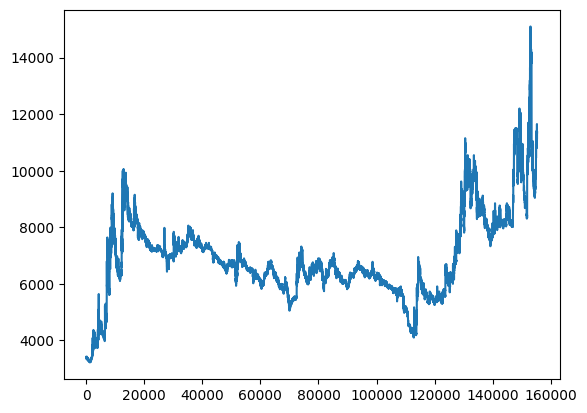

In [8]:
import matplotlib.pyplot as plt

plt.plot(res_df_.close.values)

# plt.plot(res_df_.iloc[:valid_idx[-1]].close)
# plt.plot(res_df_adj_.iloc[:valid_idx[-1]].close)

# plt.plot(res_df_adj_.close)

## kiwoom data loading

In [1]:
import sys
import os
import datetime
import pandas as pd
import sqlite3

from PyQt5.QtWidgets import *
from PyQt5.QtCore import *
from PyQt5 import uic

from kiwoomAPI import KiwoomAPI
import decorators

form_class = uic.loadUiType("Kiwoom_datareader_v0.1.ui")[0]


ModuleNotFoundError: No module named 'kiwoomAPI'

In [17]:
save_path = 'candlestick_concated/database_kiwoom/'

date = "20221214"
# date = "2022-10-24"
ftr_path = os.path.join(pkg_path, save_path, "cum", date)

# ------ load ftr list ------ #
ticker = '005930' # ETH RUNE FTM
data_list = [s for s in os.listdir(ftr_path) if "parquet" in s if date in s if ticker in s]
print(data_list)

start_0 = time.time()
key = data_list[1]  # tempoaray use single key
# res_df_ = pd.read_csv(os.path.join(ftr_path, key), index_col=0) # .set_index("index")
res_df_ = pd.read_parquet(os.path.join(ftr_path, key)) # .set_index("index")
# print(res_df_.head())
print(key, "loaded !")
print("load res_df_ elapsed time :", time.time() - start_0)

['20221214 005930_1.parquet', '20221214 005930_15.parquet']
20221214 005930_15.parquet loaded !
load res_df_ elapsed time : 0.03420877456665039


In [ ]:
res_df_

# Ticker Selection by Kiwoom

## Get ticker list by pykiwoom

In [2]:
from pykiwoom.kiwoom import *

kiwoom = Kiwoom()
kiwoom.CommConnect(block=True)
print("블록킹 로그인 완료")

state = kiwoom.GetConnectState()
if state == 0:
    print("미연결")
elif state == 1:
    print("연결완료")

블록킹 로그인 완료
연결완료


### 상하한가 요청

In [13]:
'''
시장구분 = 000:전체, 001:코스피, 101:코스닥
상하한구분 = 1:상한, 2:상승, 3:보합, 4: 하한, 5:하락, 6:전일상한, 7:전일하한
정렬구분 = 1:종목코드순, 2:연속횟수순(상위100개), 3:등락률순
종목조건 = 0:전체조회,1:관리종목제외, 3:우선주제외, 4:우선주+관리종목제외, 5:증100제외, 6:증100만 보기, 7:증40만 보기, 8:증30만 보기, 9:증20만 보기, 10:우선주+관리종목+환기종목제외
거래량구분 = 00000:전체조회, 00010:만주이상, 00050:5만주이상, 00100:10만주이상, 00150:15만주이상, 00200:20만주이상, 00300:30만주이상, 00500:50만주이상, 01000:백만주이상
신용조건 = 0:전체조회, 1:신용융자A군, 2:신용융자B군, 3:신용융자C군, 4:신용융자D군, 9:신용융자전체
매매금구분 = 0:전체조회, 1:1천원미만, 2:1천원~2천원, 3:2천원~3천원, 4:5천원~1만원, 5:1만원이상, 8:1천원이상
'''

trcode = "opt10017"
market = "001"  # kospi
updown = "2"
sort = "3"
ticker_cond = "0"
volume_cond = "0000"
debt_cond = "0"
price_cond ="0"

df = kiwoom.block_request(trcode,
                          시장구분=market,
                          상하한구분=updown,
                          정렬구분=sort,
                          종목조건=ticker_cond,
                          거래량구분=volume_cond,
                          신용조건=debt_cond,
                          매매금구분=price_cond,
                          output="상하한가",
                          next=0)

{'trcode': 'opt10017', 'input': [{'상하한가요청': ['시장구분', '상하한구분', '정렬구분', '종목조건', '거래량구분', '신용조건', '매매금구분']}], 'output': [{'상하한가': ['종목코드', '종목정보', '종목명', '현재가', '전일대비기호', '전일대비', '등락률', '거래량', '전일거래량', '매도잔량', '매도호가', '매수호가', '매수잔량', '횟수']}]}


### 가격급등락 요청

In [3]:
'''
시장구분 = 000:전체, 001:코스피, 101:코스닥, 201:코스피200
등락구분 = 1:급등, 2:급락
시간구분 = 1:분전, 2:일전
시간 = 분 혹은 일입력
거래량구분 = 00000:전체조회, 00010:만주이상, 00050:5만주이상, 00100:10만주이상, 00150:15만주이상, 00200:20만주이상, 00300:30만주이상, 00500:50만주이상, 01000:백만주이상
종목조건 = 0:전체조회,1:관리종목제외, 3:우선주제외, 5:증100제외, 6:증100만보기, 7:증40만보기, 8:증30만보기
신용조건 = 0:전체조회, 1:신용융자A군, 2:신용융자B군, 3:신용융자C군, 4:신용융자D군, 9:신용융자전체
가격조건 = 0:전체조회, 1:1천원미만, 2:1천원~2천원, 3:2천원~3천원, 4:5천원~1만원, 5:1만원이상, 8:1천원이상
상하한포함 = 0:미포함, 1:포함
'''

trcode = "opt10019" # opt10001"
market = "001"  # kospi
updown = "1"
timeunit = "2"
timeunit_cnt = "1"
volume_cond = "0000"
ticker_cond = "0"
debt_cond = "0"
price_cond ="0"
limit_price_cond = "0"

df = kiwoom.block_request(trcode,
                          시장구분=market,
                          등락구분=updown,
                          시간구분=timeunit,
                          시간=timeunit_cnt,
                          거래량구분=volume_cond,
                          종목조건=ticker_cond,
                          신용조건=debt_cond,
                          가격조건=price_cond,
                          상하한포함=limit_price_cond,
                          output="가격급등락",
                          next=0)


# kwargs = {"종목코드": code_str, "output": "주식기본정보", "next": 0}
# df = kiwoom.block_request(args=args)
# df = kiwoom.block_request(trcode, kwargs)

# code_str = "005930"

{'trcode': 'opt10019', 'input': [{'가격급등락요청': ['시장구분', '등락구분', '시간구분', '시간', '거래량구분', '종목조건', '신용조건', '가격조건', '상하한포함']}], 'output': [{'가격급등락': ['종목코드', '종목분류', '종목명', '전일대비기호', '전일대비', '등락률', '기준가', '현재가', '기준대비', '거래량', '급등률']}]}


### check data

In [ ]:
df

In [37]:
# print(df)
# print((df.급등률.dtypes))
# print(type(df.급등률[0]))
# df.종목코드[df.급등률.astype(float) > 10] # .columns
incond_df = df[df.등락률.astype(float) > 5]
 # = incond_df.종목코드 # .columns
# incond_df.종목명

In [36]:
incond_ticker_codes = ['Q' + code if 'ETN' in name else 'A' + code for code, name in zip(incond_df.종목코드, incond_df.종목명)]

#### legacy utils

In [18]:

instCpCodeMgr = win32com.client.Dispatch("CpUtil.CpCodeMgr")

In [23]:
print(kiwoom.GetMasterCodeName("610015"))
    
print(instCpCodeMgr.CodeToName("Q610015"))

메리츠 인버스 은 선물 ETN(H)
메리츠 인버스 은 선물 ETN(H)


# dumps

In [ ]:
# ------ load ftr list ------ #
ticker = 'A005930' # ETH RUNE FTM
data_list = [s for s in os.listdir(data_path) if "parquet" in s if date in s if ticker in s if '_1.' in s]
print(data_list)

start_0 = time.time()
key = data_list[0]  # tempoaray use single key
# res_df_ = pd.read_csv(os.path.join(data_path, key), index_col=0) # .set_index("index")
res_df_adj_ = pd.read_parquet(os.path.join(data_path, key)) #.set_index("date")
# print(res_df_.head())
print(key, "loaded !")
print("load res_df_ elapsed time :", time.time() - start_0)

['20221218 A005930_15_1.parquet']
20221218 A005930_15_1.parquet loaded !
load res_df_ elapsed time : 0.003991842269897461


In [4]:
account_num = kiwoom.GetLoginInfo("ACCOUNT_CNT")        # 전체 계좌수
accounts = kiwoom.GetLoginInfo("ACCNO")                 # 전체 계좌 리스트
user_id = kiwoom.GetLoginInfo("USER_ID")                # 사용자 ID
user_name = kiwoom.GetLoginInfo("USER_NAME")            # 사용자명
keyboard = kiwoom.GetLoginInfo("KEY_BSECGB")            # 키보드보안 해지여부
firewall = kiwoom.GetLoginInfo("FIREW_SECGB")           # 방화벽 설정 여부

print(account_num)
print(accounts)
print(user_id)
print(user_name)
print(keyboard)
print(firewall)

1
['8037568711']
nave94
장재원
0
0


In [83]:
kospi = kiwoom.GetCodeListByMarket('0')
kosdaq = kiwoom.GetCodeListByMarket('10')
etf = kiwoom.GetCodeListByMarket('8')

print(len(kospi))# , kospi)
print(len(kosdaq))# , kosdaq)
print(len(etf))# , etf)

1962
1616
663


In [84]:
name = kiwoom.GetMasterCodeName(code_str)
stock_cnt = kiwoom.GetMasterListedStockCnt(code_str)
stock_const = kiwoom.GetMasterConstruction(code_str)

print(name)
print(stock_cnt)
print(stock_const)

삼성전자
2147483647
정상


In [ ]:
trcode = "opt10019" # opt10001"

df = kiwoom.block_request(trcode,
                          종목코드="005930",
                          output="주식기본정보",
                          next=0)

In [32]:
df.columns

Index(['종목코드', '종목명', '결산월', '액면가', '자본금', '상장주식', '신용비율', '연중최고', '연중최저',
       '시가총액', '시가총액비중', '외인소진률', '대용가', 'PER', 'EPS', 'ROE', 'PBR', 'EV',
       'BPS', '매출액', '영업이익', '당기순이익', '250최고', '250최저', '시가', '고가', '저가',
       '상한가', '하한가', '기준가', '예상체결가', '예상체결수량', '250최고가일', '250최고가대비율',
       '250최저가일', '250최저가대비율', '현재가', '대비기호', '전일대비', '등락율', '거래량', '거래대비',
       '액면가단위', '유통주식', '유통비율'],
      dtype='object')

In [ ]:
import numpy as np
import time

kospi_data = []
kosdag_data = []
etf_data = []

# df.values
for code_str_ in (kospi):
    print(code_str_)
    kospi_data.append(kiwoom.block_request("opt10001",
                          종목코드=code_str_,
                          output="주식기본정보",
                          next=0).values)
    time.sleep(0.5)

In [ ]:
np.array(kospi_data).shape
kospi_data